In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from IPython.display import Image 

import math
import random
import codecs, json 

import cv2
import matplotlib.pyplot as plt

from sklearn import mixture
from scipy import linalg as la
from scipy import stats as st
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import numpy as np
from keras.layers import *
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf

In [2]:
# mu, sigma = 37.25, 0.875 # mean and standard deviation
# np.clip(np.random.normal(mu, sigma,5), 35,40)
np.random.uniform(35,40,5)

array([38.78002465, 36.35630119, 35.90447712, 36.55008614, 39.14782054])

In [2]:
def read_tempdata(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
    return arr

def read_gtempdata(rn,gpath,num):
    garr = np.zeros([num,rn,8,8])
    for n in range(num):
        path = gpath + str(n+1) +'.txt'
        garr[n] = read_tempdata(rn, path)
    return garr

In [3]:
dis_head = np.linspace(1,4,4)
poly_dis = np.zeros((4,4))
amb_temp = np.array([28.39548698, 27.20325227, 23.02636959, 20.02692516])
amb_dis = np.array([[ 2.06,  2.09,  2.06,  2.2 ],
       [ 0.56,  0.51,  0.98,  1.46],
       [-1.52, -1.54, -0.16,  0.59],
       [-3.3 , -2.58, -1.98, -1.42]])

for i in range(4):
    poly_dis[i] = np.polyfit(dis_head,amb_dis[i],3)
    
def get_shifttemp(ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return ans - 6.804515467387837

In [4]:
((40 + get_shifttemp(27.44472821,4)) + (35 + get_shifttemp(18.32839891,1)))/2 

28.62064660491722

In [5]:
(40 + get_shifttemp(27.44472821,4))

34.77061938132254

In [6]:
(35 + get_shifttemp(18.32839891,1))

22.4706738285119

In [7]:
def thermal_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx,8,8))
    garr2 = garr.reshape((oy,ox,8,8))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def reg_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx))
    garr2 = garr.reshape((oy,ox))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def output_interpolate(temp_path, ln2, dis):
    interpol = np.zeros((4,ln2**2,100,8,8))
    ln = 6
    bg_max = 0
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

        garr = read_gtempdata(100,datapath,ln**2)

        interpol[i] = thermal_interpolate(garr,ln**2,100,ln2**2,100)
        ln -= 1
    interpol = thermal_interpolate(interpol,4,(ln2**2)*100,dis,(ln2**2)*100)
    return interpol


def load_temperature():
    ln = 6
    dis = 16
    x_train = np.zeros((4,dis,ln**2,100,8,8))
    temp_path = np.array(['hot','warm','semicold','cold'])
    for i in range(4):
        x_train[i] = output_interpolate(temp_path[i],ln,dis).reshape(dis,ln**2,100,8,8)
    x_train = thermal_interpolate(x_train,4,(ln**2)*100*dis,16,(ln**2)*100*dis)
    x_train = x_train.reshape(16,-1,100,8,8,1).transpose(1,0,2,3,4,5)
    print("interpolation complete")
    
    
    temp_arr = np.array([27.44472821, 26.27245937, 21.30507148, 18.32839891])
    temp_inter = np.zeros(16)
    for i in range(3):
        temp_inter[i*5:(i+1)*5+1] = np.linspace(temp_arr[i],temp_arr[i+1],6)
        
    y_train = np.ones((5,16,dis,ln**2))

    y_train[1] = (np.ones((dis,ln**2,16))*temp_inter).transpose(2,0,1)
    y_train[2] = (np.ones((16,ln**2,dis))*np.linspace(1,4,dis)).transpose(0,2,1)
    pos_x = np.array([np.linspace(1,6,6),]*6)
    pos_y = pos_x.T
    y_train[3] = (np.ones((16,dis,ln**2))*pos_x.reshape(-1))
    y_train[4] = (np.ones((16,dis,ln**2))*pos_y.reshape(-1))
    y_train = y_train.reshape(5,-1)
    print("y_train[1-4] complete")
    mu, sigma = 37.25, 0.875 # mean and standard deviation
    y_temp = np.clip(np.random.normal(mu, sigma,y_train.shape[1]), 35,40)
    y_amb = y_train[1]
    for i in range(y_train.shape[1]):
        _a = y_train[1,i]
        _b = y_train[2,i]
        y_train[0,i] = (y_temp[i] + get_shifttemp(_a,_b)-29)/7
#         y_train[0,i] = (36.5-37.5)/2.5
    y_train[1] = (y_train[1]/25) -1
    y_train = y_train.reshape(5,16,-1).transpose(2,1,0)
    print("y_train complete")
    x_train2 = []
    y_train2 = []
    for k in range(16):
        for i in range(x_train.shape[0]):
            for j in range(i+1,x_train.shape[0]):
                
                _a = random.randint(0,99)
                _b = random.randint(0,99)
                 #add noise
                mu, sigma = 0, 0.08 # mean and standard deviation
#                 _na = np.clip(np.random.normal(mu, sigma, 5)*np.array([0,0,1,1,1]),-0.16,0.16)
#                 _nb = np.clip(np.random.normal(mu, sigma, 5)*np.array([0,0,1,1,1]),-0.16,0.16)
                y_train2.append(y_train[i,k])
                y_train2.append(y_train[j,k])
                y_train2.append(y_train[i,k])
                y_train2.append(y_train[j,k])
                
                _x = np.zeros((2,8,8,1))
                _xo = np.zeros((2,8,8,1))
                _xo[0] = x_train[i,k,_a]
                _xo[1] = x_train[j,k,_b]
                _x[0] = np.clip((_xo[0]-y_amb[i]-0.5)/(30.5-y_amb[i]),0,1)
                _x[1] = np.clip((_xo[1]-y_amb[j]-0.5)/(30.5-y_amb[j]),0,1)
                _x[0] = np.maximum(_x[0]*(y_temp[i]-6) + (1-_x[0])*(y_amb[i]+0.5),_xo[0]) 
                _x[1] = np.maximum(_x[1]*(y_temp[j]-6) + (1-_x[1])*(y_amb[j]+0.5),_xo[1]) 
                _xx = np.amax(_x, axis = 0)
                x_train2.append(_xx)
                x_train2.append(_xx)
                x_train2.append(_x[0])
                x_train2.append(_x[1])
                
                
               
            
    x_train2 = np.array(x_train2)
    y_train2 = np.array(y_train2)
    
    
    indices = np.arange(x_train2.shape[0])
    np.random.shuffle(indices)
    
    ind = math.floor(x_train2.shape[0]*0.2)
    ind_half = math.floor(ind*0.5)
    return x_train2[indices[:-ind]],y_train2[indices[:-ind],2:], y_train2[indices[:-ind],:2], x_train2[indices[-ind:-ind_half]], y_train2[indices[-ind:-ind_half],2:],y_train2[indices[-ind:-ind_half],:2], x_train2[indices[-ind_half:]], y_train2[indices[-ind_half:],2:], y_train2[indices[-ind_half:],:2]

In [8]:
x_train, x_train2, y_train, x_test, x_test2, y_test, x_val,x_val2, y_val = load_temperature()

print(x_train.shape)
print(x_train2.shape)
print(y_train.shape)

print(x_test.shape)
print(x_test2.shape)
print(y_test.shape)

print(x_val.shape)
print(x_val2.shape)
print(y_val.shape)

interpolation complete
y_train[1-4] complete
y_train complete
(8478720, 8, 8, 1)
(8478720, 3)
(8478720, 2)
(1059840, 8, 8, 1)
(1059840, 3)
(1059840, 2)
(1059840, 8, 8, 1)
(1059840, 3)
(1059840, 2)


In [62]:
y_train[:100]

array([[ 2.73296081e-01,  6.02765255e-02],
       [ 2.82095520e-01,  5.08983748e-02],
       [ 2.56657339e-01, -2.85798314e-02],
       [ 2.24699583e-01,  8.84109777e-02],
       [-4.74423809e-01, -2.43050663e-01],
       [ 4.18611914e-01,  8.84109777e-02],
       [ 5.23899951e-02,  7.90328270e-02],
       [-3.62447000e-01, -2.19237282e-01],
       [ 6.64721136e-02,  7.90328270e-02],
       [ 8.99627772e-02,  1.11592717e-02],
       [-2.45332821e-01, -2.43050663e-01],
       [ 8.59654467e-03, -1.71610521e-01],
       [ 2.39951179e-01,  1.11592717e-02],
       [-1.68990597e-01, -1.47797141e-01],
       [ 3.39274141e-01, -1.08058038e-01],
       [ 2.38965654e-01,  7.90328270e-02],
       [ 2.36419423e-01,  6.02765255e-02],
       [-4.90596529e-01, -2.43050663e-01],
       [ 1.19277480e-01,  5.08983748e-02],
       [ 2.66516030e-01,  8.84109777e-02],
       [-9.01491033e-02, -1.47797141e-01],
       [-3.50290940e-01, -2.43050663e-01],
       [ 4.71035898e-01, -2.85798314e-02],
       [-7.

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3, 3)         6           input_4[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 3, 3, 1)      0           dense_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_1 (Conv2DTrans (None, 8, 8, 1)      17          reshape_1[0][0]                  
_______________________________________________________________________________________

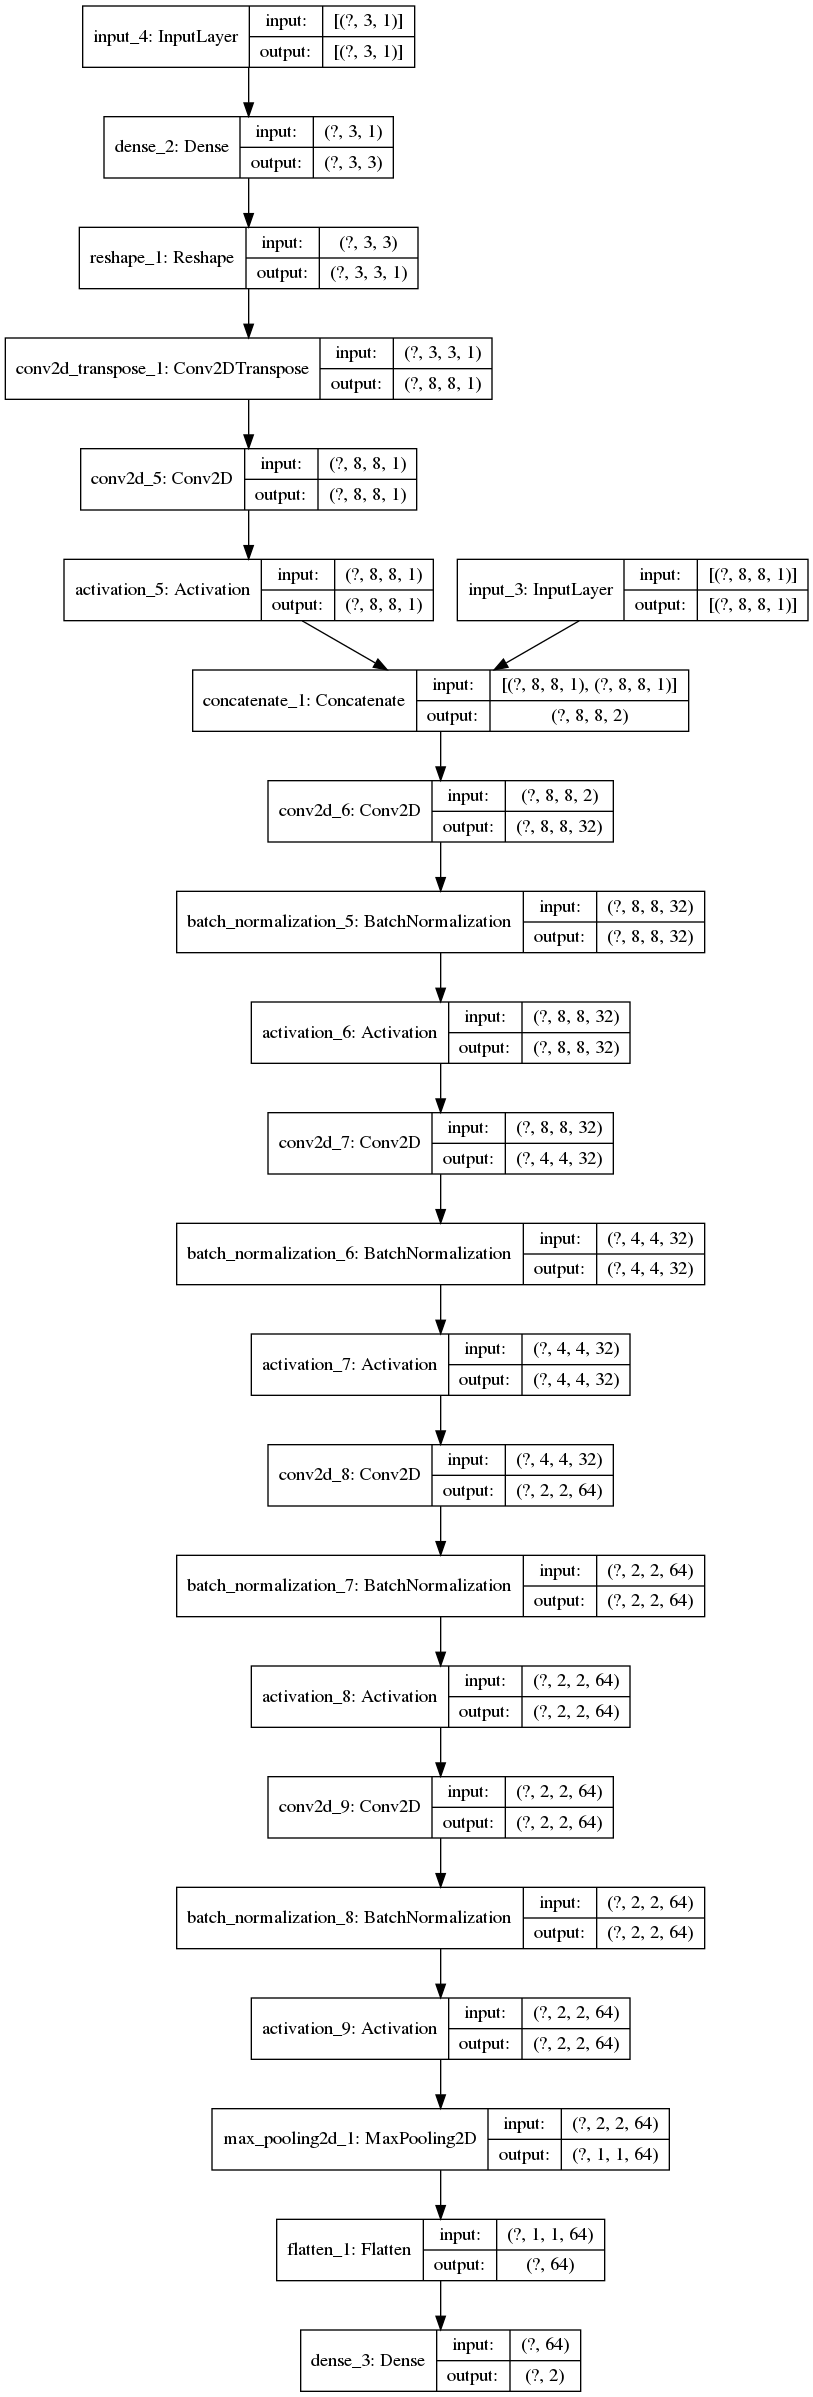

In [11]:
input_shape = (8,8,1)
input_shape2 = (3,1)
kernel_size = 3
filters = 32
dropout = 0.3
init = RandomNormal(stddev=0.02)

# use functional API to build cnn layers
inputs = Input(shape=input_shape)
inputs2 = Input(shape=input_shape2)

y2 = Dense(3, activation='relu')(inputs2)
y2 = Reshape((3,3,1))(y2)
y2 = Conv2DTranspose(1, (4,4), strides=(3,3), padding='same',output_padding = 2, kernel_initializer=init, activation = 'relu')(y2)
y2 = Conv2D(filters=1,
           kernel_size=kernel_size,
          padding = 'same')(y2)
y2 =Activation('relu')(y2)
# y2 = BatchNormalization()(y2)
# y2 =LeakyReLU(alpha=0.2)(y2)

y = Concatenate()([inputs,y2])

# y = Dropout(0.2)(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
          strides = 2,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
# y = MaxPooling2D()(y)
y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
          strides = 2,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
          padding = 'same')(y)
y = BatchNormalization()(y)
y =Activation('relu')(y)
y = MaxPooling2D()(y)

# y = Conv2D(filters=filters*4,
#            kernel_size=kernel_size)(y)
# y = BatchNormalization()(y)
# y =LeakyReLU(alpha=0.2)(y)
# y = MaxPooling2D()(y)
# y = Conv2D(filters=filters*4,
#            kernel_size=kernel_size,
#            activation='relu')(y)



# y = Dropout(dropout)(y)

# y2 = Dense(filters, activation='relu')(inputs2)
# y2 = Flatten()(y2)
# y3 = Dense(filters*8, activation='relu')(y2)


# image to vector before connecting to dense layer
y = Flatten()(y)
# y = Concatenate()([y,y3])
# y = Dense(filters*8, activation='relu')(y)
# y = Dense(filters*8, activation='relu')(y)
# dropout regularization
# y = Dropout(dropout)(y)
outputs = Dense(2, activation='tanh')(y)

# build the model by supplying inputs/outputs
model = Model(inputs=[inputs,inputs2], outputs=[outputs])
# network model in text
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

In [12]:
opt = Adam(lr=0.0001, beta_1=0.9)
model.compile(loss='mse',
              optimizer= opt,
              metrics=['accuracy'])

batch_size = 256
history = model.fit([x_train,x_train2],
          y_train,
          validation_data=([x_test,x_test2], y_test),
          epochs=200,
          batch_size=batch_size)

score = model.evaluate([x_test,x_test2], y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))
score = model.evaluate([x_val,x_val2], y_val, batch_size=batch_size)
print("\nValidation accuracy: %.1f%%" % (100.0 * score[1]))

Epoch 1/200
33120/33120 [==============================] - 91s 3ms/step - loss: 0.0087 - accuracy: 0.8419 - val_loss: 0.0078 - val_accuracy: 0.8492
Epoch 2/200
33120/33120 [==============================] - 90s 3ms/step - loss: 0.0073 - accuracy: 0.8506 - val_loss: 0.0071 - val_accuracy: 0.8565
Epoch 3/200
33120/33120 [==============================] - 89s 3ms/step - loss: 0.0069 - accuracy: 0.8553 - val_loss: 0.0071 - val_accuracy: 0.8581
Epoch 4/200
33120/33120 [==============================] - 90s 3ms/step - loss: 0.0066 - accuracy: 0.8585 - val_loss: 0.0070 - val_accuracy: 0.8574
Epoch 5/200
33120/33120 [==============================] - 88s 3ms/step - loss: 0.0064 - accuracy: 0.8613 - val_loss: 0.0072 - val_accuracy: 0.8556
Epoch 6/200
33120/33120 [==============================] - 88s 3ms/step - loss: 0.0062 - accuracy: 0.8639 - val_loss: 0.0062 - val_accuracy: 0.8629
Epoch 7/200
33120/33120 [==============================] - 90s 3ms/step - loss: 0.0060 - accuracy: 0.8661 - val_

33120/33120 [==============================] - 86s 3ms/step - loss: 0.0039 - accuracy: 0.8945 - val_loss: 0.0042 - val_accuracy: 0.8954
Epoch 57/200
33120/33120 [==============================] - 85s 3ms/step - loss: 0.0039 - accuracy: 0.8947 - val_loss: 0.0040 - val_accuracy: 0.8959
Epoch 58/200
33120/33120 [==============================] - 85s 3ms/step - loss: 0.0039 - accuracy: 0.8949 - val_loss: 0.0039 - val_accuracy: 0.8973
Epoch 59/200
33120/33120 [==============================] - 86s 3ms/step - loss: 0.0039 - accuracy: 0.8952 - val_loss: 0.0039 - val_accuracy: 0.8971
Epoch 60/200
33120/33120 [==============================] - 86s 3ms/step - loss: 0.0039 - accuracy: 0.8953 - val_loss: 0.0043 - val_accuracy: 0.8904
Epoch 61/200
33120/33120 [==============================] - 86s 3ms/step - loss: 0.0039 - accuracy: 0.8956 - val_loss: 0.0039 - val_accuracy: 0.8964
Epoch 62/200
33120/33120 [==============================] - 86s 3ms/step - loss: 0.0039 - accuracy: 0.8957 - val_loss: 

Epoch 111/200
33120/33120 [==============================] - 85s 3ms/step - loss: 0.0035 - accuracy: 0.9020 - val_loss: 0.0034 - val_accuracy: 0.9032
Epoch 112/200
33120/33120 [==============================] - 86s 3ms/step - loss: 0.0035 - accuracy: 0.9020 - val_loss: 0.0033 - val_accuracy: 0.9054
Epoch 113/200
33120/33120 [==============================] - 87s 3ms/step - loss: 0.0035 - accuracy: 0.9021 - val_loss: 0.0034 - val_accuracy: 0.9041
Epoch 114/200
33120/33120 [==============================] - 88s 3ms/step - loss: 0.0035 - accuracy: 0.9022 - val_loss: 0.0035 - val_accuracy: 0.9032
Epoch 115/200
33120/33120 [==============================] - 87s 3ms/step - loss: 0.0035 - accuracy: 0.9024 - val_loss: 0.0035 - val_accuracy: 0.9026
Epoch 116/200
33120/33120 [==============================] - 87s 3ms/step - loss: 0.0035 - accuracy: 0.9025 - val_loss: 0.0034 - val_accuracy: 0.9040
Epoch 117/200
33120/33120 [==============================] - 85s 3ms/step - loss: 0.0035 - accuracy:

33120/33120 [==============================] - 87s 3ms/step - loss: 0.0033 - accuracy: 0.9061 - val_loss: 0.0034 - val_accuracy: 0.9063
Epoch 166/200
33120/33120 [==============================] - 89s 3ms/step - loss: 0.0033 - accuracy: 0.9062 - val_loss: 0.0033 - val_accuracy: 0.9065
Epoch 167/200
33120/33120 [==============================] - 87s 3ms/step - loss: 0.0033 - accuracy: 0.9062 - val_loss: 0.0031 - val_accuracy: 0.9096
Epoch 168/200
33120/33120 [==============================] - 85s 3ms/step - loss: 0.0033 - accuracy: 0.9062 - val_loss: 0.0034 - val_accuracy: 0.9063
Epoch 169/200
33120/33120 [==============================] - 86s 3ms/step - loss: 0.0033 - accuracy: 0.9062 - val_loss: 0.0032 - val_accuracy: 0.9078
Epoch 170/200
33120/33120 [==============================] - 86s 3ms/step - loss: 0.0033 - accuracy: 0.9064 - val_loss: 0.0032 - val_accuracy: 0.9076
Epoch 171/200
33120/33120 [==============================] - 86s 3ms/step - loss: 0.0033 - accuracy: 0.9065 - val_

In [33]:
x_train[0:10,:,:,0].round(2)

array([[[25.33, 26.09, 26.08, 26.54, 25.72, 25.92, 25.87, 25.91],
        [25.56, 26.22, 27.51, 28.12, 26.62, 25.82, 25.78, 25.14],
        [25.44, 26.45, 28.93, 29.67, 28.54, 26.59, 25.61, 25.1 ],
        [25.06, 25.81, 28.36, 29.21, 29.13, 27.7 , 24.68, 23.49],
        [25.02, 25.29, 27.29, 28.23, 28.89, 27.35, 23.31, 22.7 ],
        [25.02, 26.34, 27.17, 28.24, 28.17, 26.86, 24.7 , 23.69],
        [24.79, 26.94, 27.37, 27.64, 27.88, 27.36, 26.61, 23.51],
        [24.87, 25.95, 26.91, 27.47, 27.08, 26.29, 25.68, 23.89]],

       [[24.03, 24.58, 23.84, 24.23, 24.02, 23.85, 24.08, 23.35],
        [23.92, 23.7 , 23.67, 23.8 , 24.59, 25.38, 24.13, 23.26],
        [23.98, 23.38, 22.09, 23.49, 25.01, 26.  , 24.34, 23.59],
        [23.54, 22.47, 22.1 , 23.35, 25.12, 25.89, 24.07, 22.08],
        [23.2 , 22.46, 22.39, 23.99, 27.22, 26.98, 24.79, 22.43],
        [23.05, 22.06, 22.47, 24.71, 26.89, 26.76, 24.38, 22.86],
        [22.82, 22.51, 23.25, 25.8 , 27.18, 27.12, 26.28, 23.21],
        

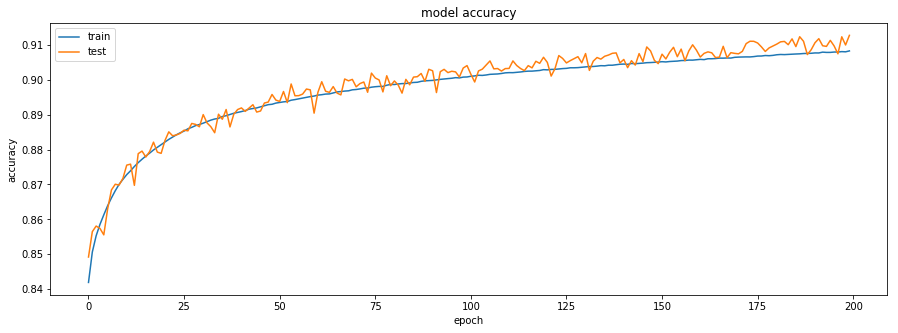

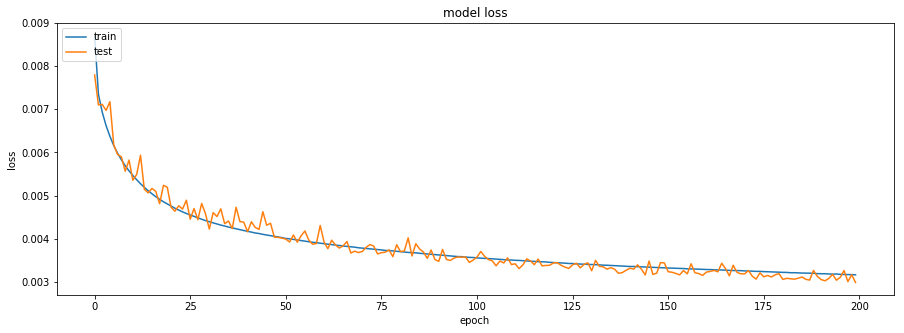

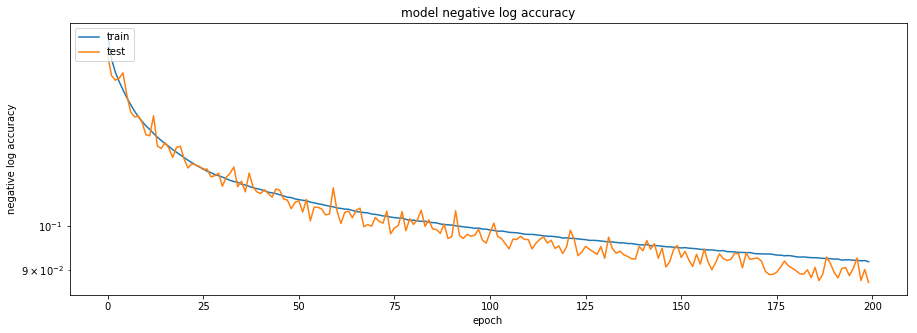

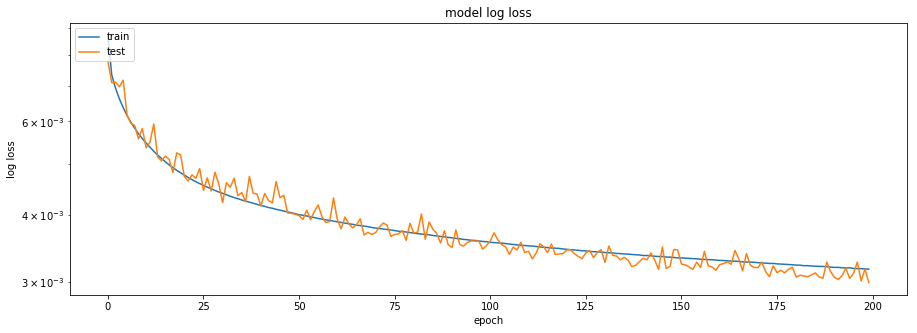

In [13]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#log

# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(1-np.array(history.history['accuracy']))
plt.plot(1-np.array(history.history['val_accuracy']))
plt.title('model negative log accuracy')
plt.ylabel('negative log accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()
# summarize history for log loss
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model log loss')
plt.ylabel('log loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()

In [14]:
def get_bodytemp(temp,ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return (temp - ans + 6.804515467387837).round(2)

In [15]:
for i in range(100):
    print(get_bodytemp(y_test[i,0]*7+29,y_test[i,1]*25+25,x_test2[i,0]))

36.54
38.93
37.91
38.13
36.35
36.19
38.01
36.3
36.66
38.21
37.08
37.87
36.33
35.86
37.7
36.71
38.0
36.26
37.25
37.85
37.33
36.79
37.84
37.53
36.22
37.11
37.6
37.2
37.49
36.78
37.42
39.42
37.55
37.9
38.6
37.08
37.52
37.27
35.45
37.62
37.27
38.92
37.81
37.26
37.29
37.4
37.37
37.48
36.61
37.03
36.96
37.11
37.05
36.81
38.05
37.47
37.79
36.74
39.84
37.6
37.37
36.49
38.06
39.07
38.15
37.86
38.07
38.11
36.88
36.89
37.87
39.2
36.78
35.75
36.45
37.57
36.05
35.71
37.15
36.54
38.61
37.19
37.71
35.93
36.66
37.13
38.7
37.48
36.46
36.9
36.72
36.0
37.34
39.26
36.96
38.25
35.92
38.03
37.4
36.21


In [16]:
res = np.array(model.predict([x_test, x_test2])*np.array([7,25])+np.array([29,25]))

In [17]:
for i in range(100):
    print(get_bodytemp(res[i,0],res[i,1],x_test2[i,0]))

37.41
36.68
37.9
38.18
36.13
36.5
38.29
37.23
36.75
37.26
36.44
37.97
36.35
37.42
37.43
36.22
38.63
36.34
37.32
37.4
37.2
36.72
37.47
37.06
36.29
37.48
37.78
36.52
37.72
37.43
37.69
39.55
37.53
36.76
37.57
37.22
37.09
35.81
36.09
37.89
37.3
38.81
37.76
37.11
36.82
36.97
36.9
37.6
36.13
36.49
36.94
36.66
36.96
36.7
37.51
37.56
37.61
36.84
37.88
37.09
37.45
36.97
37.45
37.76
37.89
37.07
37.52
38.45
36.66
37.32
37.95
37.52
36.82
37.11
36.51
37.48
36.77
37.05
37.46
36.73
38.23
37.65
37.65
35.89
36.72
36.96
38.68
37.42
37.2
36.52
36.79
36.71
37.13
38.54
36.66
38.18
36.1
37.44
37.24
37.1


In [18]:
for i in range(100):
    print(abs(get_bodytemp(res[i,0],res[i,1],x_test2[i,0]) - get_bodytemp(y_test[i,0]*7+29,y_test[i,1]*25+25,x_test2[i,0])))

0.8699999999999974
2.25
0.00999999999999801
0.04999999999999716
0.21999999999999886
0.3100000000000023
0.28000000000000114
0.9299999999999997
0.09000000000000341
0.9500000000000028
0.6400000000000006
0.10000000000000142
0.020000000000003126
1.5600000000000023
0.2700000000000031
0.490000000000002
0.6300000000000026
0.0800000000000054
0.07000000000000028
0.45000000000000284
0.12999999999999545
0.07000000000000028
0.37000000000000455
0.46999999999999886
0.07000000000000028
0.36999999999999744
0.17999999999999972
0.6799999999999997
0.22999999999999687
0.6499999999999986
0.269999999999996
0.12999999999999545
0.01999999999999602
1.1400000000000006
1.0300000000000011
0.14000000000000057
0.4299999999999997
1.4600000000000009
0.6400000000000006
0.2700000000000031
0.02999999999999403
0.10999999999999943
0.05000000000000426
0.14999999999999858
0.46999999999999886
0.4299999999999997
0.46999999999999886
0.12000000000000455
0.4799999999999969
0.5399999999999991
0.020000000000003126
0.450000000000002

In [19]:
model.save('newerer_model.h5')

In [20]:
l = []
for i in range(100):
    l.append(abs(get_bodytemp(res[i,0],res[i,1],x_test2[i,0]) - get_bodytemp(y_test[i,0]*6+29,y_test[i,1]*25+25,x_test2[i,0])))
np.median(np.array(l))

0.3249999999999993